In [5]:
import pandas as pd
import numpy as np
from utilities import loadPickle
import torch, os, math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from utilities import make_dataset, getTurns, getRawData

In [9]:
raw_data = getRawData()

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
data = make_dataset(raw_data, 2, 0.5, 30)

100%|██████████| 19/19 [03:13<00:00, 10.20s/it]


In [13]:
data.head()

,index,gaze,pose,cr,fr
0,4,"[[[0.6133377162249543, -0.19427872554668213], ...","[[[[0.78087127 2.07997589], [0.74595318 2.0637...","[1, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 1, 0, 1, 0]"
1,9,"[[[-0.029745254625555495, -0.1962147200622569]...","[[[[0.75052894 2.0526364 ], [0.72059634 2.0289...","[1, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 1, 0, 1, 0]"
2,22,"[[[-0.2506256453719234, -0.104892982378244], [...","[[[[0.74474168 2.08412226], [0.71695408 2.0664...","[1, 0, 0, 0, 1, 0, 0, 0, 1]","[1, 0, 0, 0, 1, 0, 0, 0, 1]"
3,23,"[[[0.5257884055755075, -0.17492020420261922], ...","[[[[0.76877552 2.09224932], [0.73519405 2.0746...","[1, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 1, 0, 1, 0]"
4,25,"[[[0.5312312171287068, -0.13859066453232197], ...","[[[[0.76618319 2.06413827], [0.73300457 2.0424...","[1, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 1, 0, 1, 0]"


In [18]:
df = loadPickle(r"C:\Users\irdal\OneDrive\Desktop\ResearchProgrms\RoleDetectionsModels\ExcelRefferedModels\Separate\df_updated.pth.tar")


In [19]:
df[0]

,index,ti,tf,c01_role,c02_role,c03_role,text_1,text_2,text_3,gaze1,gaze2,gaze3,file
0,0,0.0000,42.6019,SL,ML,MS,<笑>う：んう：ん,うんうんはいあ：なるほどはいはいふんふんふんうんうんうんですよね：？うんうんうんふんふんふん...,ここで：こまかく：その：百人にあった人全員から電話番号を聞かれる事とかまでを目標：にするのか...,X Y Z\n-0.966222 0.18...,X Y Z\n-0.885523 0.14...,X Y Z\n-0.988898 0.03...,20170804165000_000
1,1,42.6019,44.2444,SL,MS,ML,0,0,う：んう：ん(なん)<止>,X Y Z\n 0.576783 -0.06...,X Y Z\n-0.529464 -0.11...,X Y Z\n0.352947 -0.6241...,20170804165000_000
2,2,44.2444,45.3179,SL,MS3,SP2,<笑>,言いますもんね今で(ない)<止>,(できな)<止>いや,X Y Z\n 0.597537 -0.03...,X Y Z\n-0.498223 0.02...,X Y Z\n0.554039 -0.1000...,20170804165000_000
3,3,45.3179,46.8162,AL,MS,AL,0,(今すら)<止>今ですらないのに(みたいな)<笑>,いや違う違う,X Y Z\n-0.084541 -0.11...,X Y Z\n-0.516585 -0.07...,X Y Z\n0.611935 -0.6915...,20170804165000_000
4,4,46.8162,50.6174,SL,ML,MS,0,はいはいう：ん,たぶんね彼女に求める：レベルがきつくなると思う,X Y Z\n 0.474957 -0.32...,X Y Z\n 0.269924 -0.20...,X Y Z\n0.266528 -0.3245...,20170804165000_000


In [420]:
def cart2sph(x,y,z):
    #print(x, y, z)
    phi = math.asin(y)
    theta = x/math.cos(phi)
    return theta, phi

def cart2sphP(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = math.sqrt(XsqPlusYsq + z**2)               # r
    elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(y,x)                           # phi
    return (elev, az)

def flipGaze(gaze:np.array, person_id:int):
    temp_gaze = gaze.copy()
    if person_id == 2:
        temp    =      temp_gaze[0]
        temp_gaze[0] = temp_gaze[1]
        temp_gaze[1] = temp_gaze[2]
        temp_gaze[2] = temp
    elif person_id == 3:
        temp = temp_gaze[0]
        temp_gaze[0] = temp_gaze[2]
        temp_gaze[2] = temp
        temp_gaze[1] = temp
    else:
        return temp_gaze 
    return temp_gaze
    return "WTF are you doing!!!"

def flipRole(role:np.array, id:np.array):
    r1 = role[0:3]
    r2 = role[3:6]
    r3 = role[6:9]
    
    temp = r1
    if id == 2:
        r1 = r2
        r2 = r3
        r3 = temp
    elif id == 3:
        r1 = r3
        r3 = r2
        r2 = r1

    return np.hstack([r1, r2, r3])

def extendData(gaze:np.array,pose:np.array, cr:np.array, fr:np.array, person_id = 1):
    
    flipped_gaze = flipGaze(gaze, person_id)
    flipped_pose = flipGaze(pose, person_id)
    flipped_cr = flipRole(cr, person_id)
    flipped_fr = flipRole(fr, person_id)
    return flipped_gaze,flipped_pose, flipped_cr, flipped_fr 

def getGazeFile(session, file):
    base_path = './data/'
    people = ['video1', 'video2', 'video3']
    data = []
    for person in people:
        gaze_data = []
        for i in range(5):
            file_path = f"{base_path}{session}/{person}/{str(i*100+int(file))}.csv"
            if os.path.isfile(file_path):
                gaze_data.append(pd.read_csv(file_path))
            else:
                return "File Missing!!!"
        gaze_data = pd.concat(gaze_data)
        #print(len(gaze_data))
        if len(gaze_data)<=9000:
            gaze_data = pd.concat([gaze_data, gaze_data.iloc[[-1]*(9000 - len(gaze_data))]]) #extend the last row to make the frames equal for all three files to handle for few grames missing in some files I know not a good way
        elif len(gaze_data)>9000:
            gaze_data = gaze_data[0:9000]
        #print(len(gaze_data))
        gaze_data[['x', 'y', 'z']] = gaze_data['Gaze'].str.strip('[').str.strip(']').str.split(expand=True).astype(float)
        gaze_data[['theta', 'phi']] = gaze_data.apply(lambda row: cart2sph(row['x'], row['y'], row['z']), axis=1, result_type = 'expand').astype(float)
        data.append(gaze_data[['theta', 'phi']].to_numpy().copy())
    return np.array(data)
        
def getPoseFile(session, file):
    base_path = './data/'
    people = ['video1', 'video2', 'video3']
    data = []
    for person in people:
        pose_data = []
        for i in range(5):
            file_path = f"{base_path}{session}/pose/{person}/{str(i*100+int(file))}.npy"
            if os.path.isfile(file_path):
                pose_data.append(np.load(file_path))
            else:
                return "File Missing!!!"
        pose_data = np.vstack(pose_data)
        frames = pose_data.shape[0]
        if frames < 9000:
            last_element = pose_data[-1]
            #print(np.full(9000-frames, last_element))
            pose_data = np.concatenate([pose_data, np.concatenate([last_element[np.newaxis, ...]]* (9000-frames), axis=0)])
        elif frames >9000:
            pose_data = pose_data[0:9000]
        
        x = pose_data[:, :, 0]
        y = pose_data[:, :, 1]
        z = pose_data[:, :, 2]
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arctan2(y, x)
        phi = np.arccos(np.clip(z / r, -math.pi, math.pi))
        spherical_coordinates = np.stack((theta, phi), axis=-1)
        data.append(spherical_coordinates)
        #print(data[-1].shape)
    return np.array(data)

def getStartEndFrame1(ti, tf, fps, window, future):
    if tf-ti < window+future:
        return -1, -1 
    start_frame = int(ti + (tf-(ti+window+future))*np.random.rand())*fps 
    end_frame = start_frame + int(window*fps)
    return start_frame, end_frame

def getStartEndFrame2(ti, tf, fps, window, future):
    if tf-ti<window:
        return -1, -1
    start_frame = int((tf - (window + future)) + np.random.rand()*(future))*fps
    stop_frame = start_frame + int(fps*window)
    return start_frame, stop_frame

def getTurns(gaze_file, pose_file, start, stop, cr, fr):
    return gaze_file[:, start: stop].copy(), pose_file[:, start:stop].copy(),cr, fr
def encodeLabel(label):
    if type(label)!=str:
        return [-1]
    if 'MS' in label:
        return [1, 0, 0]
    elif 'ML' in label:
        return [0, 1, 0]
    elif 'SL' in label:
        return [0, 0, 1]
    else:
        return[-1]

def encodeRoles(label1, label2, label3):
    label1 = encodeLabel(label1)
    label2 = encodeLabel(label2)
    label3 = encodeLabel(label3)
    #print(len(label3))
    #print(label1, label2, label3)
    if len(label1)!=3 or len(label2)!=3 or len(label3)!= 3:
        return np.array([-1, -1, -1 , -1, -1 ,-1 ,-1, -1, -1])
    label = label1 + label2 + label3
    return np.array(label)


x = getPoseFile('20170720', '155000')
x.shape

C:\Users\irdal\AppData\Local\Temp\ipykernel_21856\1256643325.py:106: RuntimeWarning: invalid value encountered in divide
  phi = np.arccos(np.clip(z / r, -math.pi, math.pi))


(3, 9000, 33, 2)

In [ ]:
window = 2
future = 1
fps = 30

turns = []
for session in tqdm(raw_data.keys()):
    #print(session)
    for file in raw_data[session].keys():
        # print(file)
        #print(file)
        #load the gaze and the pose file for all the 5 files return soome flag
        gaze_file = getGazeFile(session, file)
        pose_file = getPoseFile(session, file)
        if type(gaze_file) == str or type(pose_file) == str:
            continue

        #print(gaze_file.shape, pose_file.shape)
        df = raw_data[session][file].copy()
        #print(df.head())
        #print('_________________________________')
        df['Encoded CR'] = df.apply(lambda row: encodeRoles(row['label1'], row['label2'], row['label3']), axis=1)
        df['Encoded FR'] = df['Encoded CR'].shift(-1)
        df[['start1', 'stop1']] = df.apply(lambda row:getStartEndFrame1(row['ti'], row['tf'], fps, window, future ), axis=1, result_type='expand')
        df[['start2', 'stop2']] = df.apply(lambda row:getStartEndFrame2(row['ti'], row['tf'], fps, window, future ), axis=1, result_type='expand')
        #gaze_file = getGazeFile(session, file)
        
        #print(df.head())
        turns1 = df.apply(lambda row:getTurns(gaze_file, pose_file, row['start1'], row['stop1'], row['Encoded CR'], row['Encoded CR']), axis=1)
        turns2 = df.apply(lambda row:getTurns(gaze_file, pose_file, row['start2'], row['stop2'], row['Encoded CR'], row['Encoded FR']), axis=1)
        turns.append([y for x in [turns1, turns2] for y in x if y[0].shape[1]!=0])
turns = [turn for file in turns for turn in file]
df = pd.DataFrame(columns=[['gaze','pose', 'cr', 'fr']], data=turns)
result1 = df['cr'].apply(lambda x: (x.item() == np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1])).all(), axis =1)
result2 = df['fr'].apply(lambda x: (x.item() == np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1])).all(), axis =1)
df = df[~(result1 | result2)]
df = df.dropna().reset_index()
#copty the data to three individual frames to flip and increase the data
df1 = df
df2 = df.copy()
df3 = df.copy()


      

In [ ]:
def make_dataset(raw_data, window, future, fps):
    turns = []
    for session in tqdm(raw_data.keys()):
        #print(session)
        for file in raw_data[session].keys():
            # print(file)
            #print(file)
            #load the gaze and the pose file for all the 5 files return soome flag
            gaze_file = getGazeFile(session, file)
            pose_file = getPoseFile(session, file)
            if type(gaze_file) == str or type(pose_file) == str:
                continue

            #print(gaze_file.shape, pose_file.shape)
            df = raw_data[session][file].copy()
            #print(df.head())
            #print('_________________________________')
            df['Encoded CR'] = df.apply(lambda row: encodeRoles(row['label1'], row['label2'], row['label3']), axis=1)
            df['Encoded FR'] = df['Encoded CR'].shift(-1)
            df[['start1', 'stop1']] = df.apply(lambda row:getStartEndFrame1(row['ti'], row['tf'], fps, window, future ), axis=1, result_type='expand')
            df[['start2', 'stop2']] = df.apply(lambda row:getStartEndFrame2(row['ti'], row['tf'], fps, window, future ), axis=1, result_type='expand')
            #gaze_file = getGazeFile(session, file)
            
            #print(df.head())
            turns1 = df.apply(lambda row:getTurns(gaze_file, pose_file, row['start1'], row['stop1'], row['Encoded CR'], row['Encoded CR']), axis=1)
            turns2 = df.apply(lambda row:getTurns(gaze_file, pose_file, row['start2'], row['stop2'], row['Encoded CR'], row['Encoded FR']), axis=1)
            turns.append([y for x in [turns1, turns2] for y in x if y[0].shape[1]!=0])
    turns = [turn for file in turns for turn in file]
    df = pd.DataFrame(columns=[['gaze','pose', 'cr', 'fr']], data=turns)
    result1 = df['cr'].apply(lambda x: (x.item() == np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1])).all(), axis =1)
    result2 = df['fr'].apply(lambda x: (x.item() == np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1])).all(), axis =1)
    df = df[~(result1 | result2)]
    df = df.dropna().reset_index()
    #copty the data to three individual frames to flip and increase the data
    df1 = df
    df2 = df.copy()
    df3 = df.copy()
    df2[['gaze', 'pose', 'cr', 'fr']] =df2.apply(lambda row: extendData(row['gaze'],row['pose'], row['cr'], row['fr'], 2),axis=1, result_type='expand') 
    df3[['gaze', 'pose', 'cr', 'fr']] =df3.apply(lambda row: extendData(row['gaze'],row['pose'], row['cr'], row['fr'], 3),axis=1, result_type='expand') 

    df = pd.concat([df1, df2, df3])
    return df

In [ ]:
conditions = [(2.0, 0.5), (2.0, 1.0), (2.0, 1.5), (2.0, 2.0),
              (1.5, 0.5), (1.5, 1.0), (1.5, 1.5), (1.5, 2.0)
              (1.0, 0.5), (1.0, 1.0), (1.0, 1.5), (1.0, 2.0)
              (0.5, 0.5), (0.5, 1.0), (0.5, 1.5), (0.5, 2.0)
              ]

for con in conditions:
    window = con[0]
    future = con[1]
    df = make_dataset(window, future, 30)
    with open(f"./win{window}_f{future}.pth.tar", 'wb') as handle:
        pickle.dump(df, handle)

In [432]:
data = loadPickle('./win2.0_f0.5.pth.tar')

In [1]:
import pandas as pd

In [3]:
df =pd.read_pickle('./win0.5_f0.5.pth.tar', compression=None)

In [6]:
from utilities import loadPickle
import matplotlib.pyplot as plt
acc = loadPickle('./model/accuracies_detection.tar')

IndexError: list index out of range

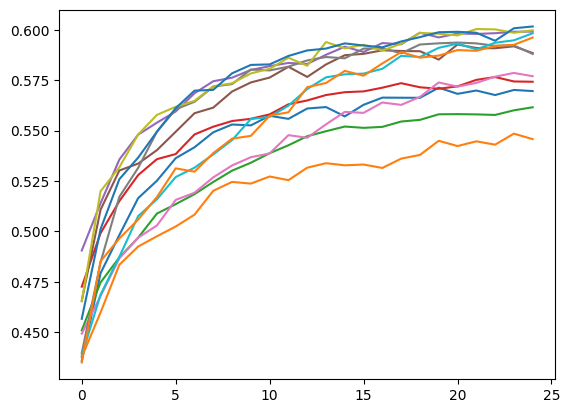

In [12]:
for i in range(16):
    plt.plot(acc[i])

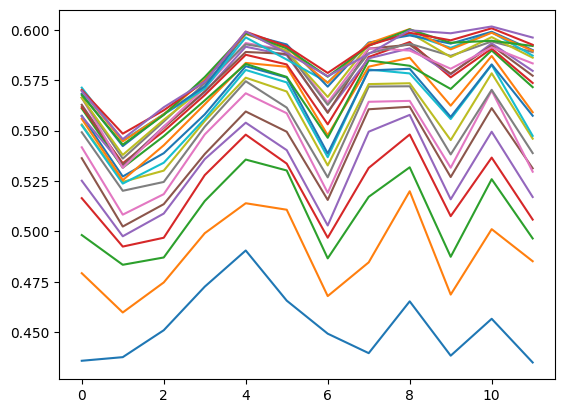

In [9]:
plt.plot(acc)